In [25]:
import pandas as pd
import numpy as np
import scorecardpy as sc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')
import pyarrow.parquet as pq
import pyarrow as pa
import pickle
import mlflow

In [2]:
url = 'data/UCI_Credit_Card.csv'

In [3]:
df = pd.read_csv(url)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
df.drop(columns=['ID'], inplace=True)
df.columns = df.columns.str.lower()
df.rename(columns={'default.payment.next.month': 'default'}, inplace=True)

In [5]:
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default'],
      dtype='object')

In [6]:
# Verificar si hay valores faltantes
print(df.isnull().sum())

limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_0        0
pay_2        0
pay_3        0
pay_4        0
pay_5        0
pay_6        0
bill_amt1    0
bill_amt2    0
bill_amt3    0
bill_amt4    0
bill_amt5    0
bill_amt6    0
pay_amt1     0
pay_amt2     0
pay_amt3     0
pay_amt4     0
pay_amt5     0
pay_amt6     0
default      0
dtype: int64


In [8]:
# Calcular la IV de todas las variables
iv_result = sc.iv(df, y="default")

# Mostrar los resultados
iv_result

,variable,info_value
2,pay_0,0.877161
13,pay_2,0.548882
22,pay_3,0.416046
1,pay_4,0.367266
11,pay_amt1,0.354998
16,pay_amt6,0.340639
17,pay_5,0.340341
12,pay_amt3,0.340153
20,pay_amt4,0.339778
19,pay_amt5,0.339478


In [9]:
df = df.drop(columns=['pay_0', 'education', 'marriage'])

In [11]:
%%capture
# Paso 3: Discretizar las variables continuas y calcular WOE e IV
features = [
    'limit_bal', 'sex', 'age', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
    'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
    'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'
]

bins = sc.woebin(df, y='default', x=features)

{'limit_bal': <Figure size 640x480 with 2 Axes>,
 'sex': <Figure size 640x480 with 2 Axes>,
 'age': <Figure size 640x480 with 2 Axes>,
 'pay_2': <Figure size 640x480 with 2 Axes>,
 'pay_3': <Figure size 640x480 with 2 Axes>,
 'pay_4': <Figure size 640x480 with 2 Axes>,
 'pay_5': <Figure size 640x480 with 2 Axes>,
 'pay_6': <Figure size 640x480 with 2 Axes>,
 'bill_amt1': <Figure size 640x480 with 2 Axes>,
 'bill_amt2': <Figure size 640x480 with 2 Axes>,
 'bill_amt3': <Figure size 640x480 with 2 Axes>,
 'bill_amt4': <Figure size 640x480 with 2 Axes>,
 'bill_amt5': <Figure size 640x480 with 2 Axes>,
 'bill_amt6': <Figure size 640x480 with 2 Axes>,
 'pay_amt1': <Figure size 640x480 with 2 Axes>,
 'pay_amt2': <Figure size 640x480 with 2 Axes>,
 'pay_amt3': <Figure size 640x480 with 2 Axes>,
 'pay_amt4': <Figure size 640x480 with 2 Axes>,
 'pay_amt5': <Figure size 640x480 with 2 Axes>,
 'pay_amt6': <Figure size 640x480 with 2 Axes>}

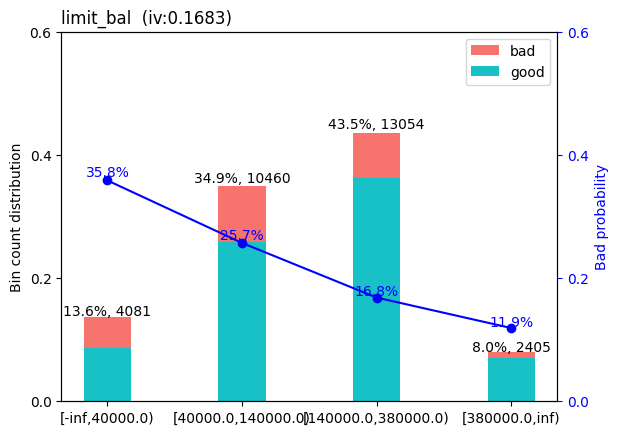

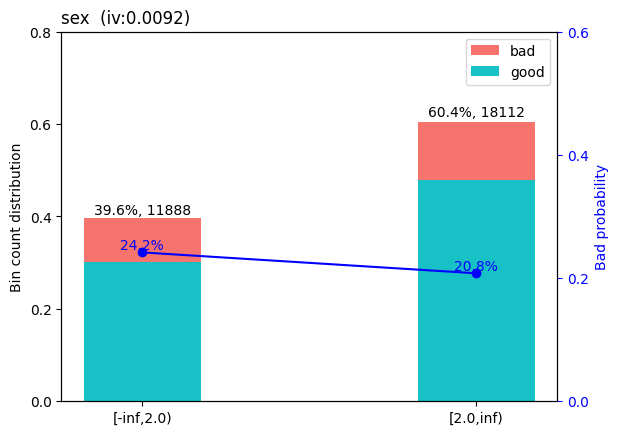

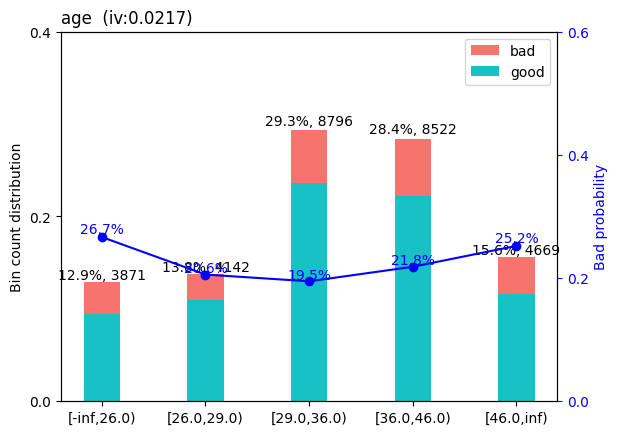

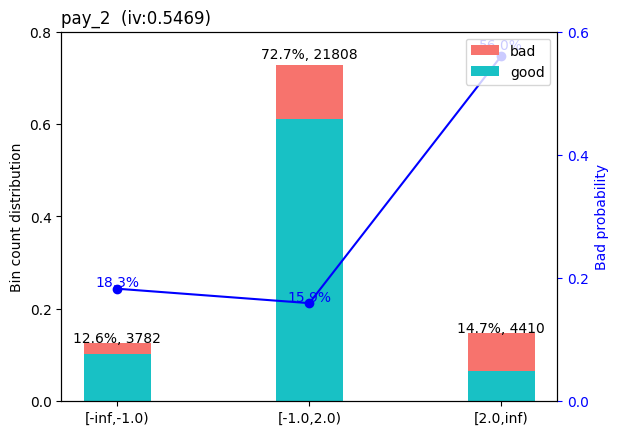

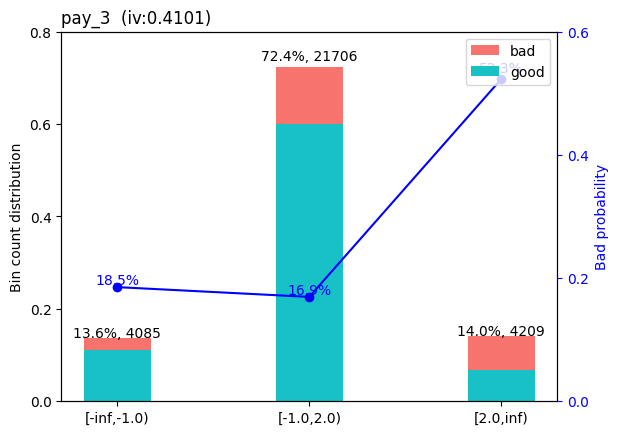

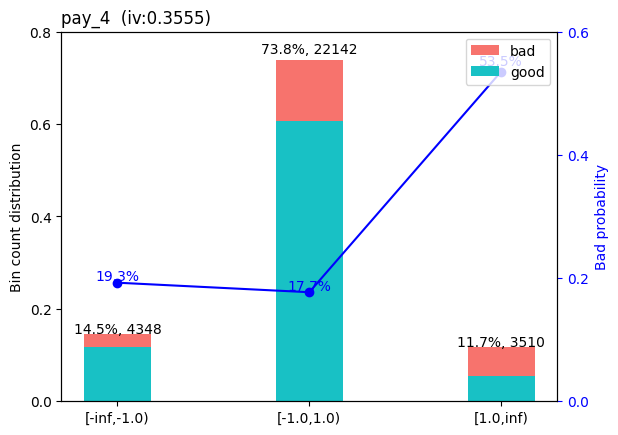

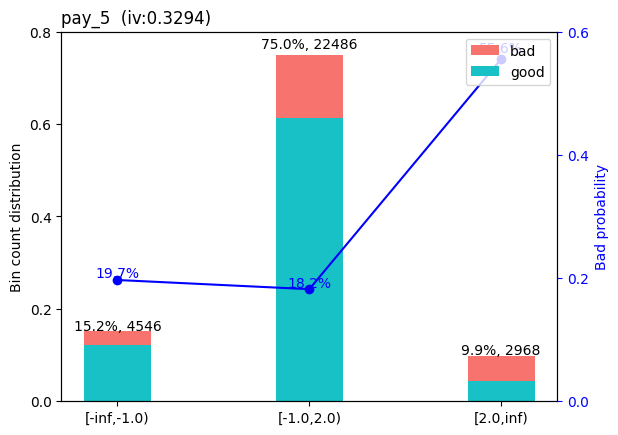

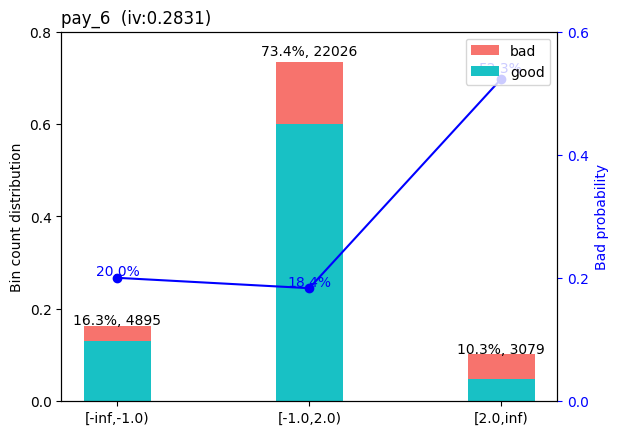

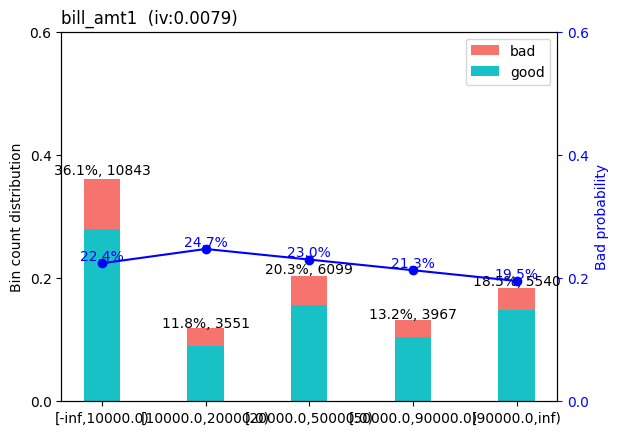

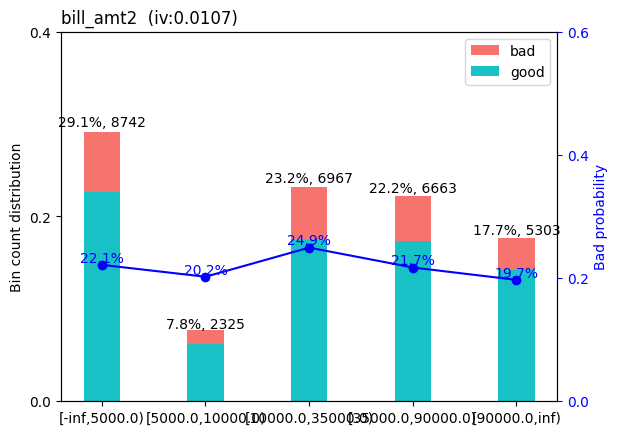

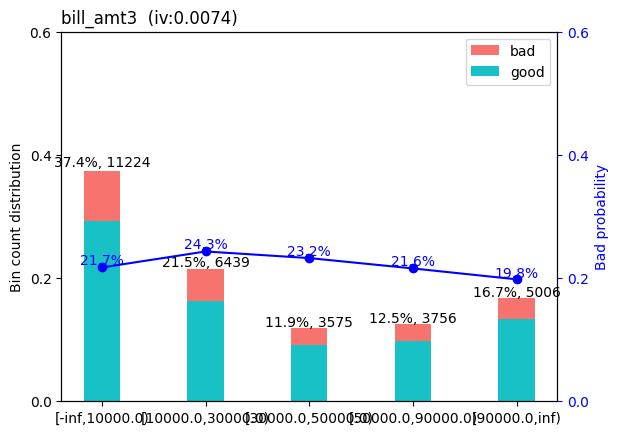

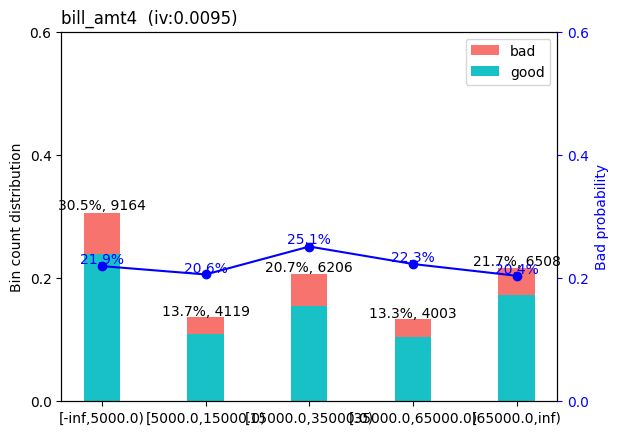

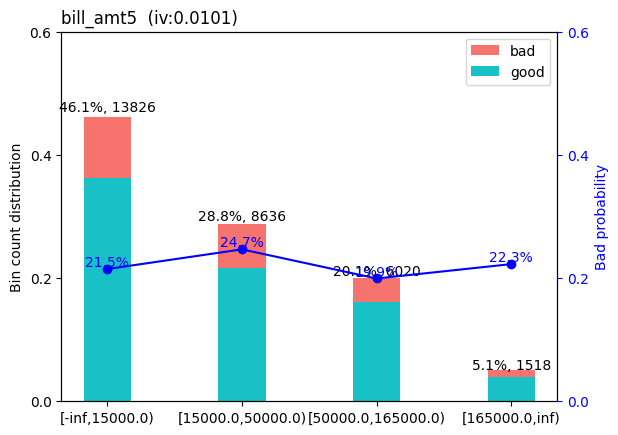

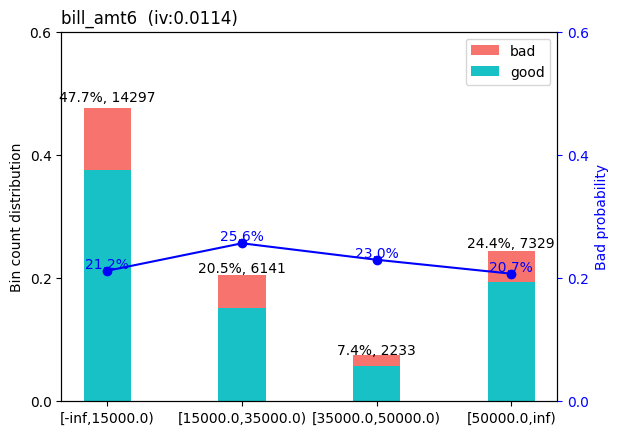

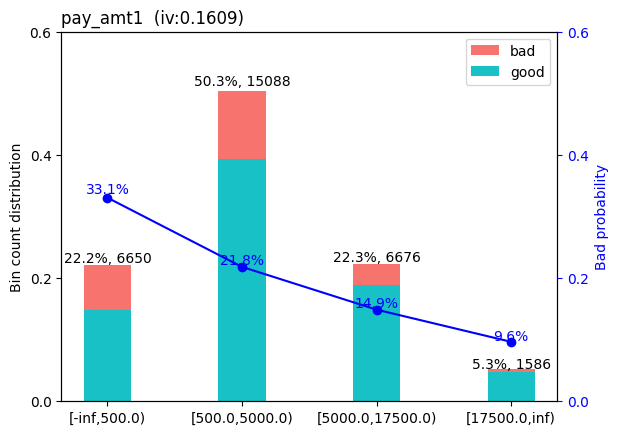

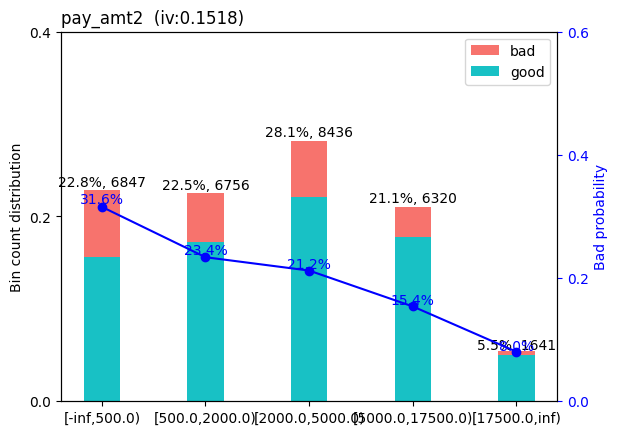

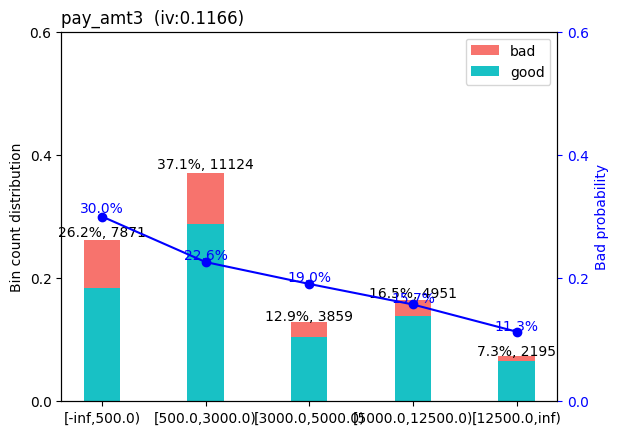

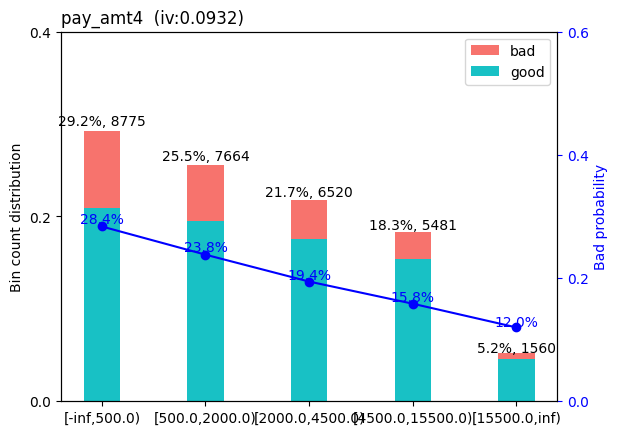

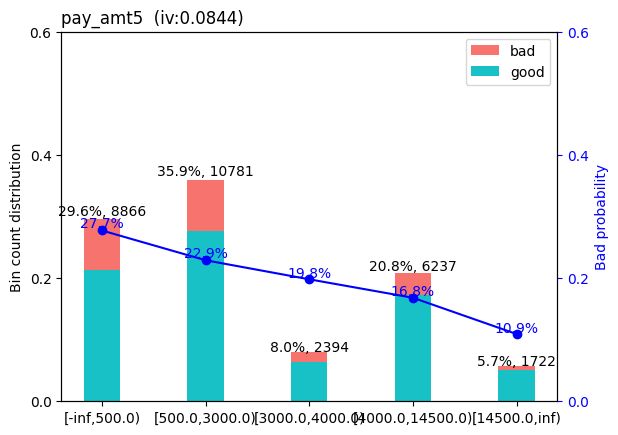

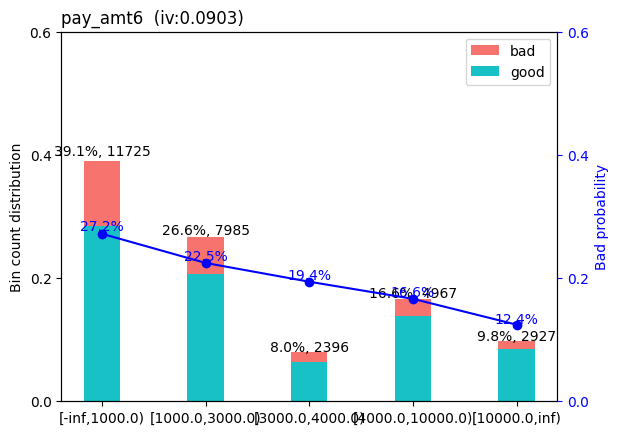

In [12]:
sc.woebin_plot(bins)

In [14]:
# Paso 4: Transformar las variables utilizando WOE
df_woe = sc.woebin_ply(df, bins)
df_woe

[INFO] converting into woe values ...


,default,pay_4_woe,bill_amt4_woe,pay_amt1_woe,sex_woe,pay_2_woe,age_woe,pay_amt6_woe,pay_amt5_woe,pay_3_woe,...,bill_amt2_woe,bill_amt3_woe,pay_amt2_woe,bill_amt1_woe,bill_amt5_woe,pay_amt3_woe,pay_5_woe,pay_6_woe,pay_amt4_woe,bill_amt6_woe
0,1,-0.277851,-0.010213,0.552881,-0.079777,1.501138,0.246734,0.273671,0.300488,-0.33087,...,0.001506,-0.023295,0.072079,0.016270,-0.038327,0.411208,-0.147246,-0.125056,0.332804,-0.054628
1,1,-0.277851,-0.010213,0.552881,-0.079777,1.501138,-0.092369,0.019319,0.300488,-0.33087,...,0.001506,-0.023295,0.072079,0.016270,-0.038327,0.027638,-0.244304,1.351641,0.094988,-0.054628
2,0,-0.277851,-0.091283,-0.017578,-0.079777,-0.404764,-0.160764,-0.353411,0.044275,-0.33087,...,0.157202,0.123502,0.072079,0.050589,-0.038327,0.027638,-0.244304,-0.233450,0.094988,0.194305
3,0,-0.277851,0.166510,-0.017578,-0.079777,-0.404764,-0.016469,0.019319,0.044275,-0.33087,...,-0.023551,0.064145,-0.053113,0.050589,0.142084,0.027638,-0.244304,-0.233450,0.094988,0.194305
4,0,-0.277851,0.166510,-0.017578,0.115154,-0.404764,0.172317,0.273671,0.044275,-0.33087,...,-0.114220,0.064145,-1.177714,0.016270,0.142084,-0.420977,-0.244304,-0.233450,-0.411755,0.194305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,-0.277851,-0.104337,-0.485817,0.115154,-0.404764,-0.016469,0.019319,-0.340970,-0.33087,...,-0.146096,-0.140391,-1.177714,-0.157202,0.142084,-0.420977,-0.244304,-0.233450,-0.163460,0.194305
29996,0,-0.277851,-0.091283,-0.017578,0.115154,-0.404764,-0.016469,0.273671,0.300488,-0.33087,...,0.001506,-0.023295,-0.053113,0.016270,-0.038327,-0.420977,-0.244304,-0.233450,0.332804,-0.054628
29997,1,-0.277851,0.166510,0.552881,0.115154,1.501138,-0.016469,-0.165069,0.044275,1.35046,...,0.001506,-0.023295,0.484679,0.016270,0.142084,-0.801929,-0.244304,-0.233450,-0.163460,0.194305
29998,1,-0.277851,0.009454,-0.978401,0.115154,-0.404764,-0.016469,0.019319,-0.840505,-0.33087,...,-0.023551,-0.032482,-0.053113,0.016270,-0.038327,0.027638,-0.244304,-0.233450,0.094988,0.048883


In [15]:
# Separar en conjuntos de entrenamiento y prueba
train, test = train_test_split(df_woe, test_size=0.2, random_state=42)


In [17]:
# Guardar los conjuntos de datos en formato Parquet
train.to_parquet('train_data/train_data.parquet', index=False)
test.to_parquet('test_data/test_data.parquet', index=False)

In [19]:
experiment_name = "credit-risk-experiment"
mlflow.set_experiment(experiment_name)

2024/06/13 15:47:50 INFO mlflow.tracking.fluent: Experiment with name 'credit-risk-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/project/python/risk/final/mlruns/837327734294192617', creation_time=1718311670128, experiment_id='837327734294192617', last_update_time=1718311670128, lifecycle_stage='active', name='credit-risk-experiment', tags={}>

In [29]:
# Separar características y etiquetas
features = ['pay_4_woe', 'bill_amt4_woe', 'pay_amt1_woe', 'sex_woe',
            'pay_2_woe', 'age_woe', 'pay_amt6_woe', 'pay_amt5_woe', 'pay_3_woe',
            'limit_bal_woe', 'bill_amt2_woe', 'bill_amt3_woe', 'pay_amt2_woe',
            'bill_amt1_woe', 'bill_amt5_woe', 'pay_amt3_woe', 'pay_5_woe',
            'pay_6_woe', 'pay_amt4_woe', 'bill_amt6_woe']
target = 'default'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# Entrenar el modelo
model = LogisticRegression(max_iter=1000)

# Iniciar un nuevo run de MLflow
with mlflow.start_run():

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Realizar predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Registrar métricas en MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc", roc_auc)

    # Registrar el modelo
    mlflow.sklearn.log_model(model, "model")

    print(f"Modelo registrado con accuracy: {accuracy} y roc_auc: {roc_auc}")


Modelo registrado con accuracy: 0.803 y roc_auc: 0.7425456582847894


In [30]:
from mlflow.models.signature import infer_signature, ModelSignature
from mlflow.types.schema import Schema, ColSpec

# Inferir la firma del modelo basado en los datos de entrenamiento
input_schema = Schema([
    ColSpec("double", "sex_woe"),
    ColSpec("double", "bill_amt3_woe"),
    ColSpec("double", "limit_bal_woe"),
    ColSpec("double", "age_woe"),
    ColSpec("double", "pay_3_woe"),
    ColSpec("double", "pay_amt4_woe"),
    ColSpec("double", "bill_amt6_woe"),
    ColSpec("double", "pay_amt2_woe"),
    ColSpec("double", "pay_amt5_woe"),
    ColSpec("double", "pay_5_woe"),
    ColSpec("double", "pay_2_woe"),
    ColSpec("double", "pay_6_woe"),
    ColSpec("double", "pay_amt3_woe"),
    ColSpec("double", "bill_amt2_woe"),
    ColSpec("double", "pay_amt1_woe"),
    ColSpec("double", "pay_4_woe"),
    ColSpec("double", "bill_amt5_woe"),
    ColSpec("double", "pay_amt6_woe"),
    ColSpec("double", "bill_amt1_woe"),
    ColSpec("double", "bill_amt4_woe")
])

# Definir el esquema de salida
output_schema = Schema([ColSpec("integer")])

# Crear la firma del modelo
signature = ModelSignature(inputs=input_schema, outputs=output_schema)


In [31]:
with mlflow.start_run() as run:
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="credit_risk_model",
        signature=signature
    )
    run_id = run.info.run_id

print(f"Run ID: {run_id}")

Run ID: 9419fdf0ff15419a957f8e458e282168


In [32]:
pip show azure-ai-ml

Name: azure-ai-ml
Version: 1.16.1
Summary: Microsoft Azure Machine Learning Client Library for Python
Home-page: https://github.com/Azure/azure-sdk-for-python
Author: Microsoft Corporation
Author-email: azuresdkengsysadmins@microsoft.com
License: MIT License
Location: c:\project\python\risk\venv\lib\site-packages
Requires: azure-common, azure-core, azure-mgmt-core, azure-storage-blob, azure-storage-file-datalake, azure-storage-file-share, colorama, isodate, jsonschema, marshmallow, msrest, opencensus-ext-azure, opencensus-ext-logging, pydash, pyjwt, pyyaml, strictyaml, tqdm, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [35]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [36]:
# Get a handle to workspace
ml_client = MLClient.from_config(credential=credential)

Found the config file in: .\config.json


In [37]:
train_data_path = "train_data/"
test_data_path = "test_data/"
data_version = "1"

In [38]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

input_train_data = "credit_train_data"
input_test_data = "credit_test_data"

try:
    # Try getting data already registered in workspace
    train_data = ml_client.data.get(
        name=input_train_data,
        version=data_version,
    )
    test_data = ml_client.data.get(
        name=input_test_data,
        version=data_version,
    )
except Exception as e:
    train_data = Data(
        path=train_data_path,
        type=AssetTypes.MLTABLE,
        description="Credit risk training data",
        name=input_train_data,
        version=data_version,
    )
    ml_client.data.create_or_update(train_data)

    test_data = Data(
        path=test_data_path,
        type=AssetTypes.MLTABLE,
        description="Credit risk test data",
        name=input_test_data,
        version=data_version,
    )
    ml_client.data.create_or_update(test_data)

Uploading train_data (0.17 MBs): 100%|##################################################################################################################| 167643/167643 [00:01<00:00, 126443.59it/s]


Uploading test_data (0.05 MBs): 100%|######################################################################################################################| 53714/53714 [00:00<00:00, 55797.61it/s]




In [39]:
# Get handle to azureml registry for the RAI built in components
registry_name = "azureml"
ml_client_registry = MLClient(
    credential=credential,
    subscription_id=ml_client.subscription_id,
    resource_group_name=ml_client.resource_group_name,
    registry_name=registry_name,
)
print(ml_client_registry)

MLClient(credential=<azure.identity._credentials.default.DefaultAzureCredential object at 0x000001BEB9F15CC0>,
         subscription_id=6c6683e9-e5fe-4038-8519-ce6ebec2ba15,
         resource_group_name=registry-builtin-prod-eastus-01,
         workspace_name=None)


In [40]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

file_model = Model(
    path="mlruns/837327734294192617/9419fdf0ff15419a957f8e458e282168/artifacts/credit_risk_model",
    type=AssetTypes.MLFLOW_MODEL,
    name="local-mlflow-credit-model",
    description="Model created from local file.",
)
model = ml_client.models.create_or_update(file_model)

Uploading credit_risk_model (0.01 MBs): 100%|#################################################################################################################| 6148/6148 [00:02<00:00, 2983.19it/s]




In [41]:
model_name = model.name
expected_model_id = f"{model_name}:1"
azureml_model_id = f"azureml:{expected_model_id}"

In [42]:
label = "latest"

rai_constructor_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_insight_constructor", label=label
)

# we get latest version and use the same version for all components
version = rai_constructor_component.version
print("The current version of RAI built-in components is: " + version)

rai_erroranalysis_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_erroranalysis", version=version
)

rai_explanation_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_explanation", version=version
)

rai_gather_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_insight_gather", version=version
)

The current version of RAI built-in components is: 0.14.0


In [47]:
from azure.ai.ml import Input, dsl
from azure.ai.ml.constants import AssetTypes

compute_name = "cluster"

@dsl.pipeline(
    compute=compute_name,
    description="RAI insights on credit data",
    experiment_name=f"RAI_insights_{model_name}",
)
def rai_decision_pipeline(
    target_column_name, train_data, test_data
):
    # Initiate the RAIInsights
    create_rai_job = rai_constructor_component(
        title="RAI dashboard credit",
        task_type="classification",
        model_info=expected_model_id,
        model_input=Input(type=AssetTypes.MLFLOW_MODEL, path=azureml_model_id),
        train_dataset=train_data,
        test_dataset=test_data,
        target_column_name=target_column_name,
    )
    create_rai_job.set_limits(timeout=300)

    # Add error analysis
    error_job = rai_erroranalysis_component(
        rai_insights_dashboard=create_rai_job.outputs.rai_insights_dashboard,
    )
    error_job.set_limits(timeout=300)

    # Add explanations
    explanation_job = rai_explanation_component(
        rai_insights_dashboard=create_rai_job.outputs.rai_insights_dashboard,
        comment="add explanation", 
    )
    explanation_job.set_limits(timeout=300)

    # Combine everything
    rai_gather_job = rai_gather_component(
        constructor=create_rai_job.outputs.rai_insights_dashboard,
        insight_3=error_job.outputs.error_analysis,
        insight_4=explanation_job.outputs.explanation,
    )
    rai_gather_job.set_limits(timeout=300)

    rai_gather_job.outputs.dashboard.mode = "upload"

    return {
        "dashboard": rai_gather_job.outputs.dashboard,
    }

In [44]:
from azure.ai.ml import Input
target_feature = "default"

credit_train_pq = Input(
    type="mltable",
    path=f"azureml:{input_train_data}:{data_version}",
    mode="download",
)
credit_test_pq = Input(
    type="mltable",
    path=f"azureml:{input_test_data}:{data_version}",
    mode="download",
)

In [45]:
import uuid
from azure.ai.ml import Output

# Pipeline to construct the RAI Insights
insights_pipeline_job = rai_decision_pipeline(
    target_column_name="default",
    train_data=credit_train_pq,
    test_data=credit_test_pq,
)

# Workaround to enable the download
rand_path = str(uuid.uuid4())
insights_pipeline_job.outputs.dashboard = Output(
    path=f"azureml://datastores/workspaceblobstore/paths/{rand_path}/dashboard/",
    mode="upload",
    type="uri_folder",
)


In [48]:
from azure.ai.ml.entities import PipelineJob
from IPython.core.display import HTML
from IPython.display import display
import time

def submit_and_wait(ml_client, pipeline_job) -> PipelineJob:
    created_job = ml_client.jobs.create_or_update(pipeline_job)
    assert created_job is not None

    print("Pipeline job can be accessed in the following URL:")
    display(HTML('<a href="{0}">{0}</a>'.format(created_job.studio_url)))

    while created_job.status not in [
        "Completed",
        "Failed",
        "Canceled",
        "NotResponding",
    ]:
        time.sleep(30)
        created_job = ml_client.jobs.get(created_job.name)
        print("Latest status : {0}".format(created_job.status))
    assert created_job.status == "Completed"
    return created_job


# This is the actual submission
insights_job = submit_and_wait(ml_client, insights_pipeline_job)

pathOnCompute is not a known attribute of class <class 'azure.ai.ml._restclient.v2023_04_01_preview.models._models_py3.UriFolderJobOutput'> and will be ignored


Pipeline job can be accessed in the following URL:


Latest status : Running
Latest status : Running
Latest status : Running


KeyboardInterrupt: 

In [71]:
X_train.columns

Index(['pay_4_woe', 'bill_amt4_woe', 'pay_amt1_woe', 'sex_woe', 'pay_2_woe',
       'age_woe', 'pay_amt6_woe', 'pay_amt5_woe', 'pay_3_woe', 'limit_bal_woe',
       'bill_amt2_woe', 'bill_amt3_woe', 'pay_amt2_woe', 'bill_amt1_woe',
       'bill_amt5_woe', 'pay_amt3_woe', 'pay_5_woe', 'pay_6_woe',
       'pay_amt4_woe', 'bill_amt6_woe'],
      dtype='object')

In [53]:
# Entrenar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [54]:
# Paso 6: Crear la scorecard
card = sc.scorecard(bins, model, X_train.columns.tolist(), points0=600, odds0=1/19, pdo=50)

In [72]:
# Guardar el objeto Scorecard en un archivo
with open('scorecard_points.pkl', 'wb') as file:
    pickle.dump(card, file)

In [73]:
# Cargar el objeto Scorecard desde el archivo
with open('scorecard_points.pkl', 'rb') as file:
    scorecard_obj = pickle.load(file)

In [67]:
data = {
    'limit_bal': [260000.0],
    'sex': [2.0],
    'age': [51.0],
    'pay_2': [-1.0],
    'pay_3': [-1.0],
    'pay_4': [-1.0],
    'pay_5': [-1.0],
    'pay_6': [2.0],
    'bill_amt1': [12261.0],
    'bill_amt2': [21670.0],
    'bill_amt3': [9966.0],
    'bill_amt4': [8517.0],
    'bill_amt5': [22287.0],
    'bill_amt6': [13668.0],
    'pay_amt1': [21818.0],
    'pay_amt2': [9966.0],
    'pay_amt3': [22301.0],
    'pay_amt4': [0.0],
    'pay_amt5': [3640.0],
    'pay_amt6': [0.0],
}

In [68]:
df_credit = pd.DataFrame(data)


In [69]:
puntaje_scores = sc.scorecard_ply(df_credit, scorecard_obj, only_total_score=True)


In [70]:
puntaje_scores

,score
0,524.0
